# Part 1: imports

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import rdkit
from rdkit import Chem
from pipeline import draw_mols

# Part 2: Assess activity of known antibacterial fragments

In [12]:
nitrofuran = 'O=[N+](O)c1ccco1'
nitro_mol = Chem.MolFromSmiles(nitrofuran)

fluoroquinolone = 'O=C(O)c2c[nH]c1ccc(F)cc1c2=O'
fluoroquino_mol = Chem.MolFromSmiles(fluoroquinolone)

carbapenem = 'O=C(O)C1=CCC2CC(=O)N12'
carbapenem_mol = Chem.MolFromSmiles(carbapenem)

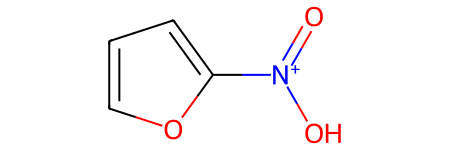

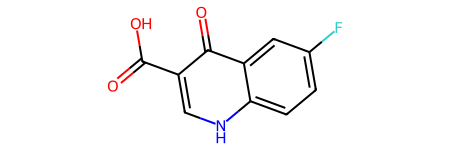

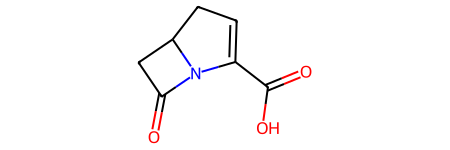

In [13]:
smis = [nitrofuran,fluoroquinolone,carbapenem]
labs = ['nitrofuran','fluoroquinolone','carbapenem',]

df = pd.DataFrame()
df['SMILES'] = smis
df['Fragment'] = labs
df['Type'] = ['Fragment'] * len(df)

# look for these fragments within our set of known antibiotics
abx = pd.read_csv('../data/static_datasets/04052022_CLEANED_v5_antibiotics_across_many_classes.csv')
abx_mols = [Chem.MolFromSmiles(smi) for smi in abx['Smiles']]

frags = [nitro_mol, fluoroquino_mol, carbapenem_mol]
for i, frag in enumerate(frags):
    display(frag)
    contains = [m.HasSubstructMatch(frag) if m is not None else False for m in abx_mols]
    curr_abx = abx[contains]
    curr_abx = curr_abx[['ChEMBL ID', 'Smiles', 'Class-Annotated']]
    curr_abx.columns = ['ChEMBL ID', 'SMILES', 'Class']
    curr_abx['Fragment'] = [labs[i]] * len(curr_abx)
    curr_abx['Type'] = ['Full Compound'] * len(curr_abx)
    
    df = pd.concat([df, curr_abx])
df.to_csv('../out/controls/known_antibiotics_containing_frags.csv', index = False)

Run from the command line (paths may be different - could also use subprocess to run within the notebook):

`chemprop_predict --test_path ../out/controls/known_antibiotics_containing_frags.csv --checkpoint_dir ../models/SA/revised_sa_model/Checkpoints/ --preds_path ../out/controls/known_antibiotics_containing_frags_with_SA_scores.csv --features_generator rdkit_2d_normalized --no_features_scaling --smiles_column SMILES`

`python ../models/chemprop-master/scripts/save_features.py --data_path ../out/controls/known_antibiotics_containing_frags.csv --features_generator rdkit_2d_normalized --save_path ../out/controls/known_antibiotics_containing_frags --smiles_column SMILES`

`chemprop_predict --test_path ../out/controls/known_antibiotics_containing_frags.csv --checkpoint_dir ../models/NG/FINALbayHO11152022/ --preds_path ../out/controls/known_antibiotics_containing_frags_with_NG_scores.csv --features_path ../out/controls/known_antibiotics_containing_frags.npz --no_features_scaling --smiles_column SMILES`

# Part 3: Make figure

In [14]:
# read back in predictions
df = pd.read_csv('../out/controls/known_antibiotics_containing_frags.csv')
df = df.reset_index(drop = True)

# SA - scores
sa_df = pd.read_csv('../out/controls/known_antibiotics_containing_frags_with_SA_scores.csv')
scores = list(sa_df['ACTIVITY'])
sa_df = df.copy()
sa_df['Score'] = scores
sa_df['Model'] = ['S. aureus'] * len(df)

# NG - scores
ng_df = pd.read_csv('../out/controls/known_antibiotics_containing_frags_with_NG_scores.csv')
scores = list(ng_df['hit'])
ng_df = df.copy()
ng_df['Score'] = scores
ng_df['Model'] = ['N. gonorrhoeae'] * len(df)

df = pd.concat([sa_df, ng_df])

/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/jackie16201/opt/anaconda3/envs/torch_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the stripplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 2400x1500 with 0 Axes>

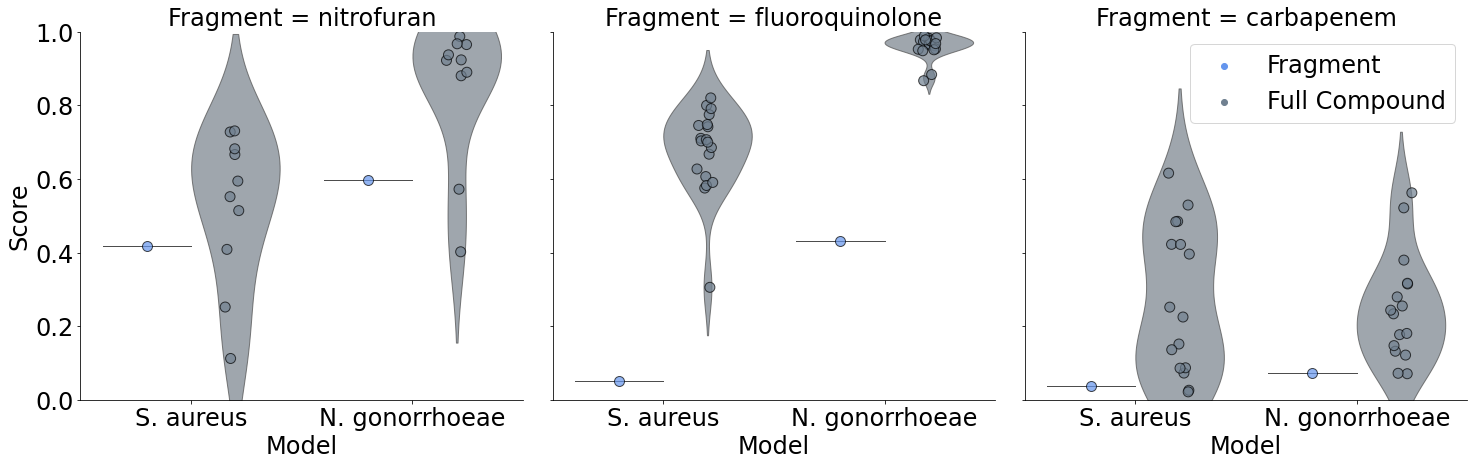

In [15]:
plt.figure(figsize=(8,5), dpi=300)
font = {'size'   : 24}
matplotlib.rc('font', **font)
    
my_pal = dict(zip(['Fragment', 'Full Compound'], ['cornflowerblue', 'slategrey']))

g = sns.FacetGrid(df, col='Fragment', height=7, aspect=1, margin_titles=True)
g.map(sns.violinplot, 'Model', 'Score', 'Type', dodge = True, edgecolor='black', linewidth = 1, errcolor = 'black', inner = None, saturation = 0.6, palette = my_pal)
g.map(sns.stripplot, 'Model', 'Score', 'Type', dodge = True, edgecolor='black', alpha = 1, linewidth = 1, s = 10, palette = my_pal)

for i, ax in enumerate(g.axes_dict.values()):
    if i == len(set(df['Fragment'])) - 1:
        
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[2:4], labels[2:4], title='', loc = 'upper right')    
    plt.xlabel('Model')
    plt.setp(ax.collections, alpha=.7)
    plt.ylim([0,1.0])
    plt.xticks(rotation = 0)
    plt.ylabel('Score')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

plt.savefig('../figure_panels/known_antibiotics_containing_frags.svg')
plt.savefig('../figure_panels/known_antibiotics_containing_frags.png')
plt.show()


In [16]:
draw_mols(frags, legends='', file_path = '../figure_panels/known_antibiotics_containing_frags_with_mols.png', black_and_white=True)

# Part 4: Check activity in vitro for these fragments

In [26]:
def analyze_activity_with_fragment(training_data, smiles_column = 'SMILES', hit_column = 'hit'): # assumes training_data is dataframe
    training_mols = [Chem.MolFromSmiles(smi) for smi in training_data['SMILES']]
    
    # collate all training data information for mols containing frags
    df = pd.DataFrame()
    for i, frag in enumerate(frags):
        contains = [m.HasSubstructMatch(frag) if m is not None else False for m in training_mols]
        curr_abx = training_data[contains]
        curr_abx = curr_abx[[smiles_column, hit_column]]
        curr_abx['Fragment'] = [labs[i]] * len(curr_abx)
        df = pd.concat([df, curr_abx])

    # now print out hit rates for each of frags
    for frag, smalldf in df.groupby('Fragment'):
        hits = sum(smalldf[hit_column])
        lendf = len(smalldf)
        print(frag + ': ' + str(int(hits)) + ' hits out of ' + str(lendf))
        print('hit rate: ' + str(np.round(100 * hits / float(lendf),3)) + '%')

In [27]:
ng = pd.read_csv('../data/training_data/NG/FULL_10_26_2022.csv')
analyze_activity_with_fragment(ng)

carbapenem: 1 hits out of 3
hit rate: 33.333%
fluoroquinolone: 28 hits out of 28
hit rate: 100.0%
nitrofuran: 34 hits out of 43
hit rate: 79.07%


In [28]:
# same for SA
training_path = '../data/training_data/SA/'
sa = pd.read_csv(training_path + '37K_sa_screen.csv') # but need to binarize and combine different SA training sets
thresh = 0.2
sa['SA_Activity'] = [1.0 if (x < thresh and y < thresh) else 0.0 for x,y in zip(sa['R1_50uM'], sa['R2_50uM'])]
sa = sa[['SA_Activity', 'SMILES']]
small = pd.read_csv(training_path + '2300_sa_screen.csv')# get 2300 dataset
small.columns = ['SMILES', 'class']
small.columns = ['SMILES', 'SA_Activity']
small = small[['SMILES', 'SA_Activity']]
sa = pd.concat([sa, small])
sa.to_csv(training_path + 'combined_SA_screen_39K.csv')

analyze_activity_with_fragment(sa, hit_column='SA_Activity')

carbapenem: 1 hits out of 3
hit rate: 33.333%
fluoroquinolone: 18 hits out of 25
hit rate: 72.0%
nitrofuran: 8 hits out of 12
hit rate: 66.667%
